# Jellyfish Classification


해파리 이미지를 분류하는 팀 프로젝트로, 아이펠 딥러닝톤에서 진행하였습니다.
---

### Library import

In [1]:
!pip install wandb

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
from PIL import Image 
import glob
import os

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from IPython.display import display, Image
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

In [3]:
wandb.login(key = "16641ea01186b6dec5b870035d74bc0cf9b1ff5c")

wandb: Currently logged in as: claireyy012 (aiffel_7th). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

## 1. 데이터 준비하기

### 데이터 살펴보기
- 전체 데이터 : 총 900 images, six different categories and species
    - 종류 별 데이터는 150개씩으로, 양적인 균형이 맞는다.
    - 데이터셋 자체가 작아 데이터를 추가 및 데이터 증강을 고려해봐야 한다.
    
- 데이터 종류 별 특징
    - Moon jellyfish : 4개의 꽃잎같은 문양이 둥근 부분에 있는 것이 특징이다.
    - Barrel jellyfish : 둥근 몸통과 굵은 다리들로 이루어져있고, 색상이 다양하여 모양으로 구분해야할 것 같다.
    - Blue jellyfish : Moon jellyfish와 비슷한 형태인데 꽃잎 문양이 없다.   
        Moon jellyfish 데이터 상에 Blue jellyfist와 유사해보이는 것들이 발견되어 이 둘의 구분이 관건일 것 같다.
    - Compass jellyfish : 몸통에 갈색 선들이 보인다.
    - Lion’s mane jellyfish : 다른 해파리에 비해 덩어리진 느낌이다. 
    - Mauve stinger : 전반적으로 점박이 문양이 있다.

특징이 비교적 뚜렷한 Moon jellyfish, Compass jellyfish, Mauve stinger 외에는 육안으로도 구분하기 어렵다.

### 데이터 로드

In [32]:
# 앞으로 필요한 변수들을 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [224, 224]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/jellyfish/Train_Test_Valid/Train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/jellyfish/Train_Test_Valid/valid/*/*'
TEST_PATH = ROOT_PATH + '/jellyfish/Train_Test_Valid/test/*/*'

# 배치 사이즈, 에폭
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


### train, valid, test data 개수 확인하기

In [5]:
# train, test, validation 각 데이터들의 개수 확인하기

train_filenames = tf.io.gfile.glob(TRAIN_PATH)  # TRAIN_PATH 내의 모든 파일에 대한 리스트를 반환하여 train_filenames 변수에 할당
test_filenames = tf.io.gfile.glob(TEST_PATH)   # TEST_PATH 내의 모든 파일에 대한 리스트를 반환하여 test_filenames 변수에 할당
val_filenames = tf.io.gfile.glob(VAL_PATH)   # VAL_PATH 내의 모든 파일에 대한 리스트를 반환하여 val_filenames 변수에 할당

train_count = len(train_filenames)
test_count = len(test_filenames)
val_count = len(val_filenames)

print("train:", train_count)
print("test:", test_count)
print("validation:", val_count)

train: 900
test: 40
validation: 39


train data는 900개, test는 40개, validation은 39개 입니다.

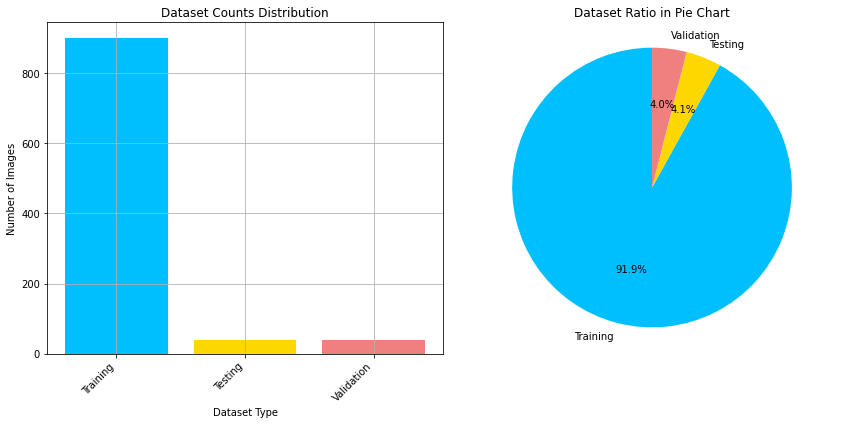

In [6]:
# visualize dataset
import matplotlib.pyplot as plt

def visualize_dataset_counts(labels, counts, colors):
    # Create the charts
    plt.figure(figsize=(12, 6))  

    # Bar Chart
    plt.subplot(121)
    plt.bar(labels, counts, color=colors)
    plt.xlabel("Dataset Type")
    plt.ylabel("Number of Images")
    plt.title("Dataset Counts Distribution")
    plt.grid(True)  # Add gridlines for visual reference
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility

    # Create the pie chart
    plt.subplot(122)  # Position the pie chart in the second subplot
    plt.pie(counts, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
    plt.title("Dataset Ratio in Pie Chart")
    plt.axis("equal")  # Ensure a circular pie chart

    # Adjust layout for better visualization
    plt.tight_layout()  # Prevent overlapping elements

    # Display the combined chart
    plt.show()


labels = ["Training", "Testing", "Validation"]
counts = [train_count, test_count, val_count]
colors = ["deepskyblue", "gold", "lightcoral"]

visualize_dataset_counts(labels, counts, colors)


In [7]:
# 데이터 리스트 확인해보기
val_filenames

['/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/Moon_jellyfish/15.jpg',
 '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/Moon_jellyfish/60.jpg',
 '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/Moon_jellyfish/27.jpg',
 '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/Moon_jellyfish/44.jpg',
 '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/Moon_jellyfish/20.jpg',
 '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/Moon_jellyfish/09.jpg',
 '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/67.jpg',
 '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/60.jpg',
 '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/10.jpg',
 '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/19.jpg',
 '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/38.jpg',
 '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_stinger_jellyfish/70.jpg',
 '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid/mauve_st

- 해파리 종의 구분은 파일 경로로 알 수 있습니다.
- train data 내의 종류 별 데이터 개수를 알아보겠습니다.

In [8]:
# train 데이터 안에 해파리 종류 별 데이터 개수 확인하기
COUNT_BARREL = len([filename for filename in train_filenames if "barrel_jellyfish" in filename])
print(f"barrel_jellyfish images count in training set: {COUNT_BARREL}")

COUNT_BLUE = len([filename for filename in train_filenames if "blue_jellyfish" in filename])
print(f"blue_jellyfish images count in training set: {COUNT_BLUE}")

COUNT_COMPASS = len([filename for filename in train_filenames if "compass_jellyfish" in filename])
print(f"compass_jellyfish images count in training set: {COUNT_COMPASS}")

COUNT_LIONS = len([filename for filename in train_filenames if "lions_mane_jellyfish" in filename])
print(f"lions_mane_jellyfish images count in training set: {COUNT_LIONS}")

COUNT_MAUVE = len([filename for filename in train_filenames if "mauve_stinger_jellyfish" in filename])
print(f"mauve_stinger_jellyfish images count in training set: {COUNT_MAUVE}")

COUNT_MOON = len([filename for filename in train_filenames if "Moon_jellyfish" in filename])
print(f"Moon_jellyfish images count in training set: {COUNT_MOON}")

barrel_jellyfish images count in training set: 150
blue_jellyfish images count in training set: 150
compass_jellyfish images count in training set: 150
lions_mane_jellyfish images count in training set: 150
mauve_stinger_jellyfish images count in training set: 150
Moon_jellyfish images count in training set: 150


- train 데이터 내 해파리 종류 별 데이터의 개수가 각 150개씩 균등하게 분포되어 있습니다.

### tf.data 인스턴스를 만들기
다양한 형태로 변형하여 활용하기 위해 데이터셋 형태로 바꿔줍니다.   

In [9]:
# train_filenames 리스트에 있는 각 파일 경로를 원소로 하는 텐서를 생성하여 훈련 데이터셋을 만듭니다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)

# val_filenames 리스트에 있는 각 파일 경로를 원소로 하는 텐서를 생성하여 검증 데이터셋을 만듭니다.
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
# Train 데이터셋, Validation 데이터셋의 크기(이미지 개수) 확인 _중복없는 데이터 개수
# numpy를 활용하면 사람이 보기 편한 형태로 반환된다.

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validation images count: {VAL_IMG_COUNT}")

# tf.data.experimental.cardinality(datasets name) : 데이터셋 이름을 입력하면 데이터셋의 크기를 반환

Training images count: 900
Validation images count: 39


### 정답 라벨 데이터를 만들어주는 함수 만들기

In [11]:
# 정답 라벨 데이터를 만들어주는 함수 만들기
# 파일 경로의 끝에서 두번째 부분을 확인하면 해파리의 종을 구분할 수 있습니다.

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    
    if parts[-2] == "barrel_jellyfish":
        return 0   # barrel_jellyfish이면 라벨 0
    
    elif parts[-2] == "blue_jellyfish":
        return 1   # blue_jellyfish이면 라벨 1
    
    elif parts[-2] == "compass_jellyfish":
        return 2   # compass_jellyfish이면 라벨 2
    
    elif parts[-2] == "lions_mane_jellyfish":
        return 3   # lions_mane_jellyfish이면 라벨 3
    
    elif parts[-2] == "mauve_stinger_jellyfish":
        return 4   # mauve_stinger_jellyfish이면 라벨 4
    
    else :
        return 5  # Moon_jellyfish이면 라벨 5

decode_img 함수와 process_path 함수를 만들겠습니다.
- process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다.
- get_label을 이용해서 라벨 값을 가져옵니다.

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정. 보통 0에서 255 사이의 정수값을 0에서 1 사이의 부동소수점 값으로 조정하는 과정이다.
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다.
- num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 줄 수 있습니다.

In [13]:
# 데이터셋에 process_path 함수를 적용하기
# 활용한 map()함수가 데이터셋(train_list_ds, val_list_ds)의 각 요소에 함수(process_path)를 적용하여 변환하는 역할

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape: (224, 224, 3)
Image type: <dtype: 'float32'>
Label: 0


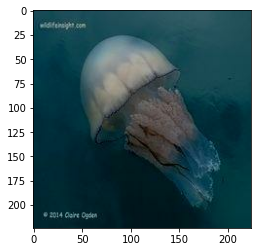

In [14]:
# 이미지 Resize가 잘 되었는지, 라벨이 잘 들어가있는지 확인하기
for image, label in train_ds.take(1):
    print("Image shape:", image.numpy().shape)
    print("Image type:", image.dtype)
    print("Label:", label.numpy())
    
plt.figure
plt.imshow(image.numpy())

# train_ds.take(1)은 하나의 데이터만 가져온다는 의미

In [15]:
# # train, validation data 나누기 - 데이터셋 X 
# !pip install train
# from train import load_data

# train_filenames = tf.io.gfile.glob(TRAIN_PATH)  # TRAIN_PATH 내의 모든 파일에 대한 리스트를 반환하여 train_filenames 변수에 할당
# (x_train, y_train)=load_data(train_filenames)
# val_filenames = tf.io.gfile.glob(VAL_PATH) 
# (x_valid, y_valid)=load_data(val_filenames, number_of_data=567)
# x_train_norm = x_train/255.0     # 입력은 0~1 사이의 값으로 정규화
# x_valid_norm = x_valid/255.0

# print("x_train shape: {}".format(x_train.shape))
# print("y_train shape: {}".format(y_train.shape))

### Test dataset 만들기
train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다.  
그리고 데이터 개수도 확인하겠습니다.

In [16]:
# test dataset 만들기

# TEST_PATH 디렉토리 내의 모든 파일을 원소로 하는 텐서를 생성하여 테스트 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
# test dataset의 크기(이미지 개수) 확인 _넘파이 배열로 변환하여
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
# 이미지 파일의 경로를 입력하여 이미지와 라벨을 출력하는 함수 & AUTOTUNE 변수 적용
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# 데이터셋을 배치 단위로 묶기
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

40


현재 Train data는 총 900개로 매우 적은 데이터셋입니다.  
따라서 학습이 잘 이루어질 수 있도록 데이터 증강 기법을 활용해보겠습니다.  
- 회전 : 해파리 데이터의 경우 다양한 방향으로 움직이는 것을 확인할 수 있습니다. 따라서 다양한 각도의 이미지를 추가해보도록 하겠습니다.

In [17]:
# 회전 augmentation

def augment(image, label):
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # 0, 90, 180, 270도 중에서 무작위로 회전합니다.
    return image, label

Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.  
tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.  

- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.  
- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데,   
이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.  
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.  

- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.  
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.  

- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에,  
첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.  

In [18]:
# [참고] TensorFlow의 ImageDataGenerator를 사용하면 회전 augmentation을 비롯한 다양한 이미지 변환을 손쉽게 적용할 수 있습니다.

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range=40,  # 회전 범위: 40도 이내로 회전
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # ... (데이터셋 생성 코드)

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

# # 데이터셋 변환 적용
# train_ds = train_ds.map(lambda x, y: (datagen.random_transform(x), y))

In [19]:
# prepare_for_training 함수로 데이터 변환 및 파이프라인 세팅

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment,      # augment(회전) 함수 적용
        num_parallel_calls=2
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
test_ds = prepare_for_training(test_ds)

### 데이터 시각화
학습용 데이터를 시각화해서 확인합니다.  
회전 augmentation이 제대로 처리되었는지 show_batch() 함수를 통해 확인합니다.

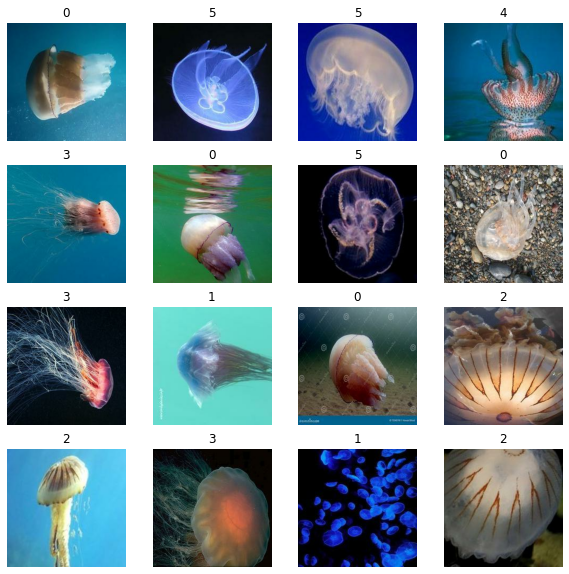

In [20]:
# 이미지 배치를 입력하면 여러 장의 이미지를 라벨과 함께 보여줍니다. 

import math

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        # math.ceil(BATCH_SIZE/4)는 배치 크기를 4로 나눈 결과를 올림하여 필요한 행의 수를 계산
        # n이 아닌 n+1인 이유 : 인덱스가 0부터 시작하므로 1번째 이미지는 n+1이 되어야 합니다.
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])   # 현재 서브플롯에 이미지를 표시
        
        # 현재 이미지에 대한 라벨을 가져오기
        label = label_batch[n].numpy()
        
        # 라벨을 기반으로 타이틀 지정
        plt.title(label)
        plt.axis("off")

# 훈련 데이터셋으로부터 하나의 배치를 가져오기 - iter(train_ds)로부터 next함수를 사용하여 다음 배치를 추출
image_batch, label_batch = next(iter(train_ds))
# show_batch 함수를 사용하여 훈련 데이터셋의 일부 이미지를 시각화
show_batch(image_batch.numpy(), label_batch)

In [21]:
# 이미지 Resize가 잘 되었는지, 라벨이 잘 들어가있는지 확인하기

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Data type: ", image.dtype)
    print("Label: ", label.numpy())
    
# train_ds.take(1)은 하나의 데이터만 가져온다는 의미

Image shape:  (16, 224, 224, 3)
Data type:  <dtype: 'float32'>
Label:  [2 2 4 3 0 1 3 5 0 1 3 5 1 0 3 0]


설정한 사이즈로 잘 통일된 것을 확인할 수 있습니다.

## 모델 구현

In [86]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [24]:
# 모델 구현

def build_model(pool_size=7, num_classes=6):

    inputs = keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    x = keras.layers.SeparableConv2D(64, kernel_size=(3,3), strides=1, padding='same')(inputs)
    x = tf.keras.layers.experimental.preprocessing.Normalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = keras.layers.Conv2D(128, kernel_size=(3,3), strides=1, padding='same')(x)
    x = tf.keras.layers.experimental.preprocessing.Normalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = keras.layers.Conv2D(256, kernel_size=(3,3), strides=1, padding='same')(x)
    x = tf.keras.layers.experimental.preprocessing.Normalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = keras.layers.Conv2D(128, kernel_size=(3,3), strides=1, padding='same')(x)
    x = tf.keras.layers.experimental.preprocessing.Normalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = keras.layers.Conv2D(64, kernel_size=(3,3), strides=1, padding='same')(x)
    x = tf.keras.layers.experimental.preprocessing.Normalization()(x)
    x = keras.layers.GlobalAveragePooling2D()(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

In [25]:
# gpu로 모델 빌드, 컴파일

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint
check_point_cb = ModelCheckpoint('basic_cnn.keras')
# early stopping
early_stopping_cb = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = ['accuracy']
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=METRICS
    )

In [26]:
# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 224, 224, 64)      283       
_________________________________________________________________
normalization (Normalization (None, 224, 224, 64)      129       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 128)     73856     
_________________________________________________________________
normalization_1 (Normalizati (None, 112, 112, 128)     257       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0     

In [28]:
# Calculate the number of batches
num_batches = tf.data.experimental.cardinality(train_ds).numpy() // BATCH_SIZE

print(f'Total batches: {num_batches}')

Total batches: -1


In [30]:
# gpu로 모델학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callbacks=[check_point_cb, early_stopping_cb]
    )

Epoch 1/10
56/56 [==============================] - 58s 108ms/step - loss: 1.8748 - accuracy: 0.2266 - val_loss: 1.6886 - val_accuracy: 0.3125
Epoch 2/10
56/56 [==============================] - 6s 103ms/step - loss: 1.7054 - accuracy: 0.2734 - val_loss: 1.7284 - val_accuracy: 0.3125
Epoch 3/10
56/56 [==============================] - 6s 103ms/step - loss: 1.7068 - accuracy: 0.2958 - val_loss: 1.6879 - val_accuracy: 0.2500
Epoch 4/10
56/56 [==============================] - 6s 104ms/step - loss: 1.6869 - accuracy: 0.3025 - val_loss: 1.8268 - val_accuracy: 0.1562
Epoch 5/10
56/56 [==============================] - 6s 104ms/step - loss: 1.6992 - accuracy: 0.2913 - val_loss: 1.5756 - val_accuracy: 0.3750
Epoch 6/10
56/56 [==============================] - 6s 105ms/step - loss: 1.6448 - accuracy: 0.3058 - val_loss: 1.4822 - val_accuracy: 0.3750
Epoch 7/10
56/56 [==============================] - 6s 106ms/step - loss: 1.6391 - accuracy: 0.3281 - val_loss: 1.4701 - val_accuracy: 0.3750
Epoch

In [31]:
# 모델 저장
model.save('cnn_model')

# history 저장
import os
import pickle

# Specify the directory path
directory_path = '/aiffel/aiffel/DLthon'

# Ensure the directory exists, create it if not
os.makedirs(directory_path, exist_ok=True)

# Full file path
file_path = os.path.join(directory_path, 'cnn_train_history_dict.pkl')

# Assuming history.history is defined somewhere in your code
with open(file_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
# # history 불러오기 테스트
# history = pickle.load(open('/trainHistoryDict', "rb"))
# print(history)

INFO:tensorflow:Assets written to: cnn_model/assets


### 실험1 : 배치사이즈 200으로, 에폭 30으로 조정

In [33]:
# 배치사이즈를 16 -> 200, epochs을 10 -> 30으로 조정
BATCH_SIZE = 200
EPOCHS = 10

In [34]:
# checkpoint
check_point_cb = ModelCheckpoint('basic_cnn.keras')
# early stopping
early_stopping_cb = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = ['accuracy']
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=METRICS
    )

In [35]:
# gpu로 모델학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callbacks=[check_point_cb, early_stopping_cb]
    )

Epoch 1/10
4/4 [==============================] - 2s 122ms/step - loss: 2.6342 - accuracy: 0.1094
Epoch 2/10
4/4 [==============================] - 0s 113ms/step - loss: 2.3863 - accuracy: 0.1562
Epoch 3/10
4/4 [==============================] - 0s 112ms/step - loss: 1.7847 - accuracy: 0.2656
Epoch 4/10
4/4 [==============================] - 0s 113ms/step - loss: 1.8216 - accuracy: 0.2656
Epoch 5/10
4/4 [==============================] - 0s 115ms/step - loss: 1.8389 - accuracy: 0.1875
Epoch 6/10
4/4 [==============================] - 0s 113ms/step - loss: 1.8203 - accuracy: 0.3125
Epoch 7/10
4/4 [==============================] - 0s 114ms/step - loss: 1.6912 - accuracy: 0.2969
Epoch 8/10
4/4 [==============================] - 0s 114ms/step - loss: 1.7288 - accuracy: 0.1875
Epoch 9/10
4/4 [==============================] - 0s 117ms/step - loss: 1.6003 - accuracy: 0.3750
Epoch 10/10
4/4 [==============================] - 0s 111ms/step - loss: 1.7603 - accuracy: 0.3438


---
아래는 이전 시도

### 데이터 전처리 - 이미지 사이즈 통일하기

In [31]:
# 이미지 사이즈 224x224로 통일하기

from PIL import Image 

def resize_images(img_path):
    images=glob.glob(img_path + "/*")
    
    print(len(images), " images resized.")
    
    target_size=(224,224)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(len(images), " images resized.")
    return images
    
    
# Train 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + '/aiffel/jellyfish/Train_Test_Valid/Train/*'
resize_images(image_dir_path)

print("Train 이미지 resize 완료!")

# test 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + '/aiffel/jellyfish/Train_Test_Valid/test/*'
resize_images(image_dir_path)

print("test 이미지 resize 완료!")

# valid 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + '/aiffel/jellyfish/Train_Test_Valid/valid/*'
resize_images(image_dir_path)

print("valid 이미지 resize 완료!")

900  images resized.
900  images resized.
Train 이미지 resize 완료!
40  images resized.
40  images resized.
test 이미지 resize 완료!
39  images resized.
39  images resized.
valid 이미지 resize 완료!


In [32]:
# 이미지 사이즈 확인

image1 = Image.open( os.getenv("HOME") + "/aiffel/jellyfish/Train_Test_Valid/Train/blue_jellyfish/02.jpg")
print(image1)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7F7085768A00>


train, test, valid data의 모든 이미지가 224*224로 리사이즈 되었습니다.

### 해파리 종류 별 데이터를 읽을 수 있는 load_data() 함수 만들기
load_data() 함수는 입력으로 이미지가 있는 폴더 위치를 받습니다.   
총 6개의 클래스이므로 아래와 같이 라벨링이 됩니다.  
- Barrel jellyfish : 0
- Blue jellyfish : 1
- Compass jellyfish : 2
- Lion’s mane jellyfish : 3 
- Mauve stinger : 4
- Moon jellyfish : 5

In [37]:
import numpy as np

def load_data(img_path, number_of_data=900):   # 150개씩 총 900장의 이미지 데이터
    
    img_size=224
    color=3
    
    import glob
    import os

    Barrel_images = glob.glob(img_path + "/barrel_jellyfish/*")
    Blue_images = glob.glob(img_path + "/blue_jellyfish/*")
    Compass_images = glob.glob(img_path + "/compass_jellyfish/*")
    Lion_images = glob.glob(img_path + "/lions_mane_jellyfish/*")
    Mauve_images = glob.glob(img_path + "/mauve_stinger_jellyfish/*")
    Moon_images = glob.glob(img_path + "/Moon_jellyfish/*")
    print("Barrel_images:", len(Barrel_images))
    print("Blue_images:", len(Blue_images))
    print("Compass_images:", len(Compass_images))
    print("Lion_images:", len(Lion_images))
    print("Mauve_images:", len(Mauve_images))
    print("Moon_images:", len(Moon_images))
    
    # 이미지 데이터와 라벨(0~5) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    
    idx=0
    for file in glob.iglob(img_path+'/barrel_jellyfish/*'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # Barrel jellyfish : 0
        idx=idx+1
        
    for file in glob.iglob(img_path+'/blue_jellyfish/*'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # Blue jellyfish : 1
        idx=idx+1
        
    for file in glob.iglob(img_path+'/compass_jellyfish/*'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # Compass jellyfish : 2
        idx=idx+1
        
    for file in glob.iglob(img_path+'/lions_mane_jellyfish/*'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # Lion’s mane jellyfish : 3
        idx=idx+1
        
    for file in glob.iglob(img_path+'/mauve_stinger_jellyfish/*'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # Mauve stinger : 4
        idx=idx+1
        
    for file in glob.iglob(img_path+'/Moon_jellyfish/*'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # Moon jellyfish : 5
        idx=idx+1
        
    print("데이터(이미지)의 개수는", idx,"입니다.")   # 학습, 검증 데이터의 개수
    return imgs, labels

# 학습 데이터
image_dir_path = os.getenv("HOME") + "/aiffel/jellyfish/Train_Test_Valid/Train"
(x_train, y_train)=load_data(image_dir_path)
# 검증 데이터
image_dir_path = os.getenv("HOME") + "/aiffel/jellyfish/Train_Test_Valid/valid"
(x_valid, y_valid)=load_data(image_dir_path, number_of_data=567)

# 정규화 - 학습 데이터, 검증 데이터
x_train_norm = x_train/255.0     # 입력은 0~1 사이의 값으로 정규화
x_valid_norm = x_valid/255.0

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

Barrel_images: 150
Blue_images: 150
Compass_images: 150
Lion_images: 150
Mauve_images: 150
Moon_images: 150
데이터(이미지)의 개수는 900 입니다.
Barrel_images: 5
Blue_images: 7
Compass_images: 7
Lion_images: 7
Mauve_images: 7
Moon_images: 6
데이터(이미지)의 개수는 39 입니다.
x_train shape: (900, 224, 224, 3)
y_train shape: (900,)


> 학습데이터(x_train)의 개수는 900개  
> 검증데이터(x_valid)의 개수는 39개

### 이미지 불러와서 확인하기
- np.random.randint : 전체 이미지를 리스트로 불러와 그 중 랜덤으로 1개 선택하여 확인
- 현재 아래와 같이 나열되어있는 이미지가 잘 라벨링 되어있는지 확인
    - Barrel jellyfish : 0
    - Blue jellyfish : 1
    - Compass jellyfish : 2
    - Lion’s mane jellyfish : 3
    - Mauve stinger : 4
    - Moon jellyfish : 5

605


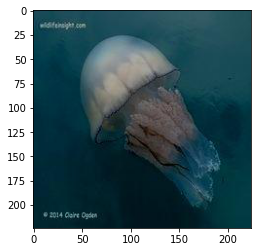

In [40]:
import matplotlib.pyplot as plt

idx=np.random.randint(low=0, high=1200, size=1)[0]
print(idx)

plt.imshow(x_train[0])
# print('라벨: ', y_train[0])
# plt.imshow(x_train[idx+150])
# print('라벨: ', y_train[idx+150])
# plt.imshow(x_train[idx+300])
# print('라벨: ', y_train[idx+300])
# plt.imshow(x_train[idx+450])
# print('라벨: ', y_train[idx+450])
# plt.imshow(x_train[idx+600])
# print('라벨: ', y_train[idx+600])
# plt.imshow(x_train[idx+750])
# print('라벨: ', y_train[idx+750])
# plt.imshow(x_train[idx+900])
# print('라벨: ', y_train[idx+900])

> 주석 풀었을 때 idx 문제 해결하기.  
현재 인덱스가 종류 별로 순서대로 있지 않고, 총 데이터 개수보다 더 큰 숫자의 인덱스가 있는 것으로 보임

## 2. 모델 만들기
오버피팅 억제를 위해 아래 3가지를 활용하였다.  

- 가중치 초기화 : Relu에 특화된 He 초기값 사용. 모든 층에서 활성화값들을 균일하게 분포시킴  
- 배치 정규화 : 각 층이 활성화를 적당히 퍼트리도록 강제하는 역할. 아래와 같은 이점이 있다.  
    - 학습 속도를 개선
    - 초기값에 크게 의존하지 않음
    - 오버피팅을 억제
- 드롭아웃 : 신경망 모델이 복잡해진 경우 오버피팅을 억제하는 방식

In [41]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import optimizers

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(input_shape=(224,224,3), filters=16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(224,224,3), filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(224,224,3), filters=16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax', kernel_initializer='he_normal'))
          
print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  13
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (N

## 3. Trainer 만들기
- 학습률 0.001
- Adam을 활용하여 매개변수 최적화를 시도

In [42]:
# model compile

learning_rate = 0.001
adam = optimizers.Adam(learning_rate = learning_rate)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [43]:
# model fit

history = model.fit(x_train_norm, y_train, batch_size = 64, validation_data=(x_valid_norm, y_valid), epochs = 20, verbose = 1)

Epoch 1/20
15/15 [==============================] - 9s 170ms/step - loss: 1.5269 - accuracy: 0.3700 - val_loss: 0.9985 - val_accuracy: 0.9612
Epoch 2/20
15/15 [==============================] - 1s 72ms/step - loss: 1.0878 - accuracy: 0.3933 - val_loss: 1.3120 - val_accuracy: 0.0335
Epoch 3/20
15/15 [==============================] - 1s 71ms/step - loss: 1.0142 - accuracy: 0.4200 - val_loss: 2.1150 - val_accuracy: 0.0317
Epoch 4/20
15/15 [==============================] - 1s 74ms/step - loss: 0.9809 - accuracy: 0.4411 - val_loss: 2.1192 - val_accuracy: 0.0317
Epoch 5/20
15/15 [==============================] - 1s 73ms/step - loss: 0.9934 - accuracy: 0.4633 - val_loss: 4.4870 - val_accuracy: 0.0265
Epoch 6/20
15/15 [==============================] - 1s 72ms/step - loss: 0.9508 - accuracy: 0.4700 - val_loss: 5.1811 - val_accuracy: 0.0300
Epoch 7/20
15/15 [==============================] - 1s 72ms/step - loss: 0.9254 - accuracy: 0.5178 - val_loss: 5.7655 - val_accuracy: 0.0265
Epoch 8/20
1

### train, validation data의 정확도 시각화

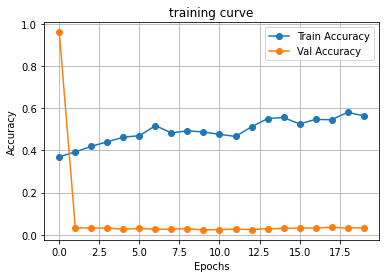

In [44]:
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('training curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
wandb.login(key = "16641ea01186b6dec5b870035d74bc0cf9b1ff5c")

wandb: Currently logged in as: claireyy012 (aiffel_7th). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [ ]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.00001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

### 모델 성능 향상 시도

In [ ]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(input_shape=(224,224,3), filters=16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(224,224,3), filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(224,224,3), filters=16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax', kernel_initializer='he_normal'))

In [45]:
# 모델 함수 생성

def ResNet18(pool_size=7):
    # Input layer 정의 및 residual module 생성
    inputs = keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    # conv1
    x = keras.layers.SeparableConv2D(64, kernel_size=(7,7), strides=2, padding='same')(inputs)
    x = keras.layers.BatchNormalization(pool_size=3, strides=2, padding='same')(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = keras.layers.Conv2D(64, kernel_size=(7,7), strides=2, padding='same')(x)
    x = residual_module(x, 64)
    
    # con3_x : Residual_block
    x = residual_module(x, 128)
    x = residual_module(x, 128)
    
    # con4_x : Residual_block
    x = residual_module(x, 256)
    x = residual_module(x, 256)
    
    # con5_x : Residual_block
    x = residual_module(x, 512)
    x = residual_module(x, 512)
    
    # Average Pool Layer : 마지막 층
    x = keras.layers.AveragePooling2D(pool_size)(x)
    x = keras.layers.Dense(1000, activation='softmax')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)

    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs, name='resnet18_model')
    
    return model

In [46]:
# GPU 사용
with tf.device('/GPU:0'):
    resnet_model = ResNet18()
    resnet_model.summary()     # 모델 summary()로 확인

    # 평가 지표 설정
    METRICS = ['accuracy']
    
    # 학습률 설정
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    
    # 모델 컴파일
    resnet_model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=METRICS
    )

NameError: name 'residual_module' is not defined